In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6) # (32,12)

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import preprocessing_data

In [4]:
# 'data/csv/oving5/0141126194/Partner.csv'
# 'data/csv/oving5/0141126194/Card.csv'
df = preprocessing_data.get_df_from_csv('data/csv/oving5/1395669706/Partner.csv')

In [5]:
df.isnull().sum()

SourceEdit1               130
SizeMeasure1              130
WarningCount1             130
SourceEdit_ErrorCount1    130
StoredString1             222
Start1                    131
End1                      131
JunitTest1                424
FailureCount1             424
Completion1               424
SuccessCount1             424
JunitTest_ErrorCount1     424
Launch1                   382
dtype: int64

In [6]:
preprocessing_data.patching_source_code(df)

# Experiments

In [7]:
preprocessing_data.fill_nan_columns(df)
preprocessing_data.create_relative_time_column(df)
preprocessing_data.aggregate_columns(df)

c:\users\herman\appdata\local\conda\conda\envs\jexercise\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Experiment #2
Using the **df** from earlier!

In [8]:
df

,SourceEdit1,SizeMeasure1,WarningCount1,SourceEdit_ErrorCount1,StoredString1,Start1,End1,JunitTest1,FailureCount1,Completion1,...,Relative_time,Active_time,SourceEdit,JunitTest,Launch,TotalSizeMeasure,TotalCompletion,TotalJunitTest_ErrorCount,TotalSourceEdit_ErrorCount,TotalErrorCount
2017-02-22 19:54:17,1.0,6.0,0.0,0.0,package objectstructures;\r\n\r\npublic class ...,NaN,NaN,0.0,0.0,0.0,...,00:00:00,2017-02-22 19:54:17,1,0,0,6.0,0.0,0.0,0.0,0.0
2017-02-22 19:54:23,1.0,7.0,0.0,0.0,NaN,53.0,-6.0,0.0,0.0,0.0,...,00:00:06,2017-02-22 19:54:23,1,0,0,7.0,0.0,0.0,0.0,0.0
2017-02-22 20:01:09,1.0,9.0,0.0,0.0,Partner() {\r\n\t\t\r\n\t},52.0,-6.0,0.0,0.0,0.0,...,00:06:52,2017-02-22 20:01:09,1,0,0,9.0,0.0,0.0,0.0,0.0
2017-02-22 20:01:21,1.0,9.0,0.0,4.0,"String name,",60.0,-15.0,0.0,0.0,0.0,...,00:07:04,2017-02-22 20:01:21,1,0,0,9.0,0.0,0.0,4.0,4.0
2017-02-22 20:04:46,1.0,9.0,0.0,0.0,Partner partner,73.0,-15.0,0.0,0.0,0.0,...,00:10:29,2017-02-22 20:04:46,1,0,0,9.0,0.0,0.0,0.0,0.0
2017-02-22 20:04:56,1.0,11.0,0.0,2.0,private name;\r\n\t,52.0,-53.0,0.0,0.0,0.0,...,00:10:39,2017-02-22 20:04:56,1,0,0,11.0,0.0,0.0,2.0,2.0
2017-02-22 20:05:01,1.0,12.0,0.0,2.0,private Partner partner,67.0,-56.0,0.0,0.0,0.0,...,00:10:44,2017-02-22 20:05:01,1,0,0,12.0,0.0,0.0,2.0,2.0
2017-02-22 20:05:03,1.0,12.0,2.0,0.0,String,60.0,-87.0,0.0,0.0,0.0,...,00:10:46,2017-02-22 20:05:03,1,0,0,12.0,0.0,0.0,0.0,0.0
2017-02-22 20:05:55,1.0,13.0,2.0,0.0,this.name = name;\r\n\t\tthis.partner = partner;,144.0,-9.0,0.0,0.0,0.0,...,00:11:38,2017-02-22 20:05:55,1,0,0,13.0,0.0,0.0,0.0,0.0
2017-02-22 20:05:57,1.0,15.0,2.0,0.0,\t,193.0,-6.0,0.0,0.0,0.0,...,00:11:40,2017-02-22 20:05:57,1,0,0,15.0,0.0,0.0,0.0,0.0


In [9]:
not_debugging = slice(None, '2017-02-22 20:09:02')
debugging = slice('2017-02-22 20:09:02', '2017-02-22 22:20:32')
completed = slice('2017-02-22 22:20:32', None)

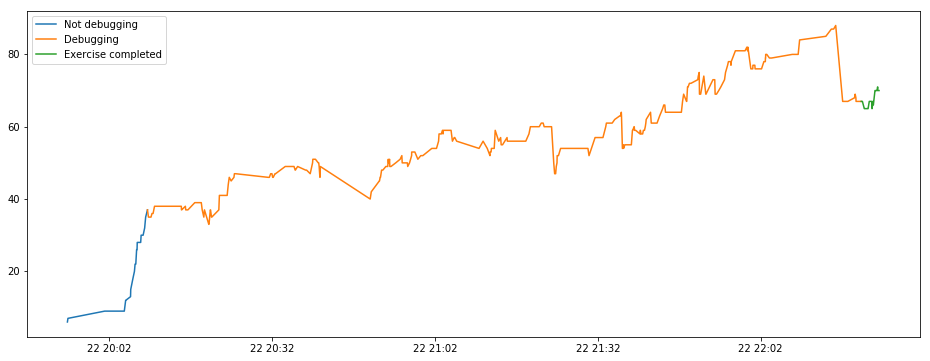

In [10]:
plt.figure(figsize=(16,6))
plt.plot(df[not_debugging].SizeMeasure1, label='Not debugging')
plt.plot(df[debugging].SizeMeasure1, label='Debugging')
plt.plot(df[completed].SizeMeasure1, label='Exercise completed')
plt.legend()

In [11]:
df['TotalRuns'] = df.JunitTest + df.Launch

In [29]:
# Char diff
df['Char_diff_between_runs'] = np.nan
df['Acc_char_diff_between_runs'] = np.nan

df['Char_diff_between_5min_runs'] = np.nan
df['Acc_char_diff_between_5min_runs'] = np.nan

df['Char_diff_between_5min_runs_all'] = np.nan
df['Acc_char_diff_between_5min_runs_all'] = np.nan

# Line diff
df['Line_diff_between_runs'] = np.nan
df['Acc_line_diff_between_runs'] = np.nan

df['Line_diff_between_5min_runs'] = np.nan
df['Acc_line_diff_between_5min_runs'] = np.nan

df['Line_diff_between_5min_runs_all'] = np.nan
df['Acc_line_diff_between_5min_runs_all'] = np.nan

# Completion
df['Completion_diff_between_5min_runs'] = np.nan
df['Completion_diff_between_5min_runs_all'] = np.nan

df['Runs_between_5min_runs'] = np.nan
df['Runs_between_5min_runs_all'] = np.nan

In [30]:
only_runs = df[df.TotalRuns == 1]

In [31]:
# Character diff between two runs
for i in range(1, len(only_runs)):
    prev_row = only_runs.iloc[i - 1]
    cur_row = only_runs.iloc[i]
    df.Char_diff_between_runs.at[cur_row.name] = preprocessing_data.get_diff_length(prev_row.SourceCode1, cur_row.SourceCode1)
    df.Line_diff_between_runs.at[cur_row.name] = preprocessing_data.get_diff_length_lines(prev_row.SourceCode1,
                                                                                          cur_row.SourceCode1)

In [32]:
window_start = only_runs.iloc[0].name
for i2 in range(1, len(only_runs)):
    cur_row = only_runs.iloc[i2]
    if cur_row.name - window_start >= dt.timedelta(seconds=5*60):
        prev_row = only_runs.loc[window_start]
        df.Char_diff_between_5min_runs.at[cur_row.name] = preprocessing_data.get_diff_length(prev_row.SourceCode1,
                                                                            cur_row.SourceCode1)
        df.Line_diff_between_5min_runs.at[cur_row.name] = preprocessing_data.get_diff_length_lines(prev_row.SourceCode1,
                                                                            cur_row.SourceCode1)
        window_start = cur_row.name
        
        # Completion
        df.Completion_diff_between_5min_runs.at[cur_row.name] = cur_row.Completion1 - prev_row.Completion1
        
        # Run freq
        df.Runs_between_5min_runs.at[cur_row.name] = len(only_runs.loc[prev_row.name:cur_row.name]) - 2

In [33]:
period = dt.timedelta(seconds=5 * 60)

In [34]:
# Defining the start index as the first run 5 minutes after the first run.
# 'backfill' makes sure it picks the next index, i.e. greater than 5 minutes if no exact match
start_idx = only_runs.index.get_loc(only_runs.index[0] + period, method='backfill')

In [35]:
for i3 in range(start_idx, len(only_runs)):
    cur_row = only_runs.iloc[i3]
    # We get the first (oldest) run which is at least 5 minutes earlier
    prev_row = only_runs.iloc[only_runs.index.get_loc(only_runs.index[i3] - period, method='pad')]
    df.Char_diff_between_5min_runs_all.at[cur_row.name] = preprocessing_data.get_diff_length(prev_row.SourceCode1,
                                                                                             cur_row.SourceCode1)
    df.Line_diff_between_5min_runs_all.at[cur_row.name] = preprocessing_data.get_diff_length_lines(prev_row.SourceCode1,
                                                                                                   cur_row.SourceCode1)
    # Completion
    df.Completion_diff_between_5min_runs_all.at[cur_row.name] = cur_row.Completion1 - prev_row.Completion1
    
    # Run freq
    df.Runs_between_5min_runs_all.at[cur_row.name] = len(only_runs.loc[prev_row.name:cur_row.name]) - 2

In [36]:
# Accumulated character diff between runs
cumsum = 0
cumsum_lines = 0
for j in range(0, len(df)):
    # We keep the sum of character diff since the last run
    if not pd.isnull(df.Character_diff1.iat[j]):
        cumsum += df.Character_diff1.iat[j]
        cumsum_lines += df.Line_diff1.iat[j]
    if df.TotalRuns.iat[j] == 1:
        df.Acc_char_diff_between_runs.iat[j] = cumsum
        df.Acc_line_diff_between_runs.iat[j] = cumsum_lines
        cumsum = 0
        cumsum_lines = 0

In [37]:
window_start = only_runs.iloc[0].name
cumsum = 0
cumsum_lines = 0
for j2 in range(df.index.get_loc(window_start) + 1, len(df)):
    cur_row = df.iloc[j2]
    if not pd.isnull(cur_row.Character_diff1):
        cumsum += cur_row.Character_diff1
        cumsum_lines += cur_row.Line_diff1
    # Checking if there is a run on the current row and there has been at least 5 minutes since last run:
    if cur_row.TotalRuns == 1 and cur_row.name - window_start >= dt.timedelta(seconds=5*60):
        df.Acc_char_diff_between_5min_runs.at[cur_row.name] = cumsum
        df.Acc_line_diff_between_5min_runs.at[cur_row.name] = cumsum_lines
        cumsum = 0
        cumsum_lines = 0
        window_start = cur_row.name

In [38]:
for j3 in range(start_idx, len(only_runs)):
    cur_row = only_runs.iloc[j3]
    # We get the first (oldest) run which is at least 5 minutes earlier
    prev_row = only_runs.iloc[only_runs.index.get_loc(only_runs.index[j3] - period, method='pad')]
    acc_char_diff = df.loc[prev_row.name:cur_row.name].Character_diff1.sum()
    acc_line_diff = df.loc[prev_row.name:cur_row.name].Line_diff1.sum()
    df.Acc_char_diff_between_5min_runs_all.at[cur_row.name] = acc_char_diff
    df.Acc_line_diff_between_5min_runs_all.at[cur_row.name] = acc_line_diff

In [39]:
only_runs = df[df.TotalRuns == 1]

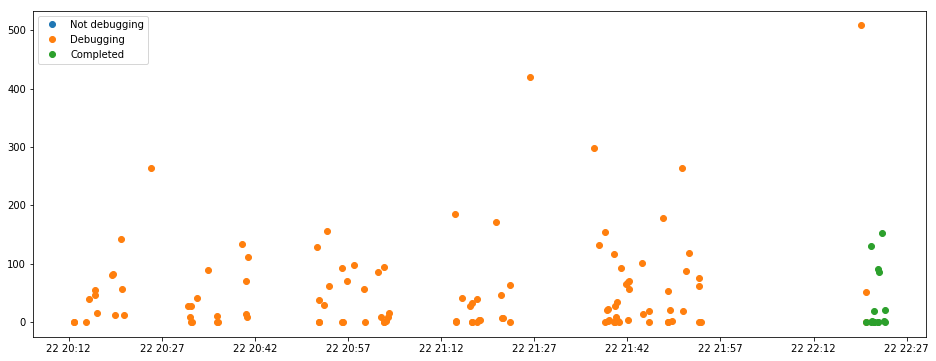

In [41]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Char_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Char_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Char_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

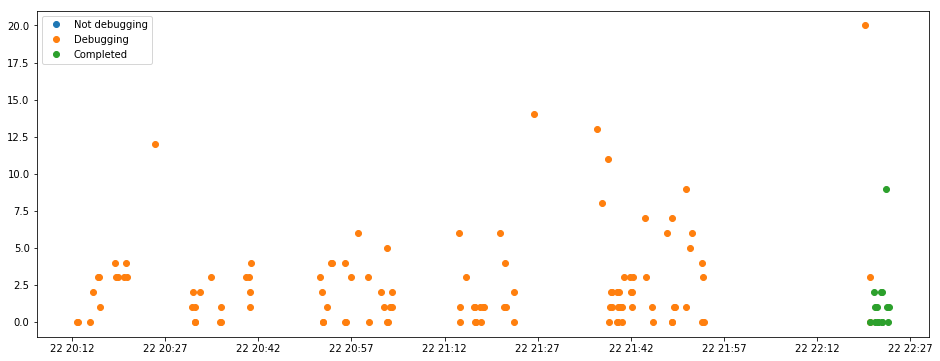

In [44]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Line_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Line_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Line_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

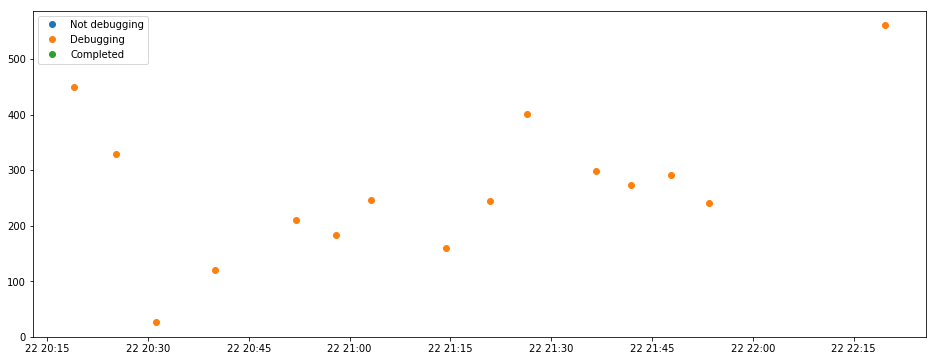

In [42]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Char_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Char_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Char_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

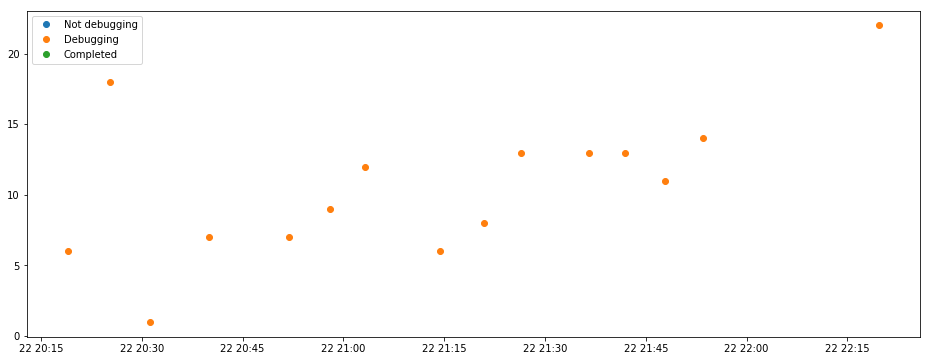

In [45]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Line_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Line_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Line_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

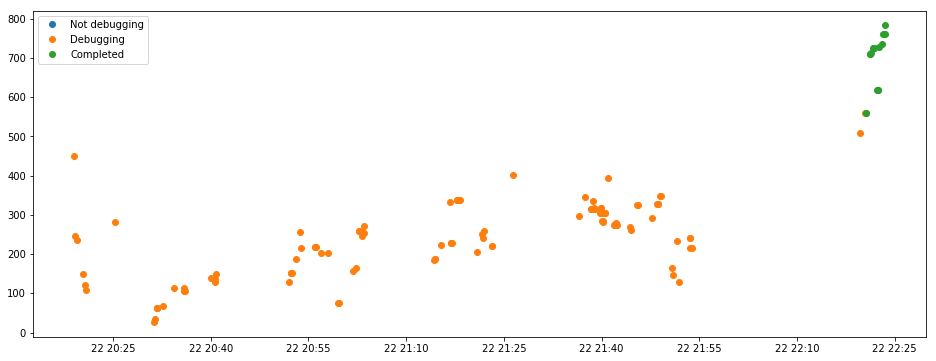

In [43]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

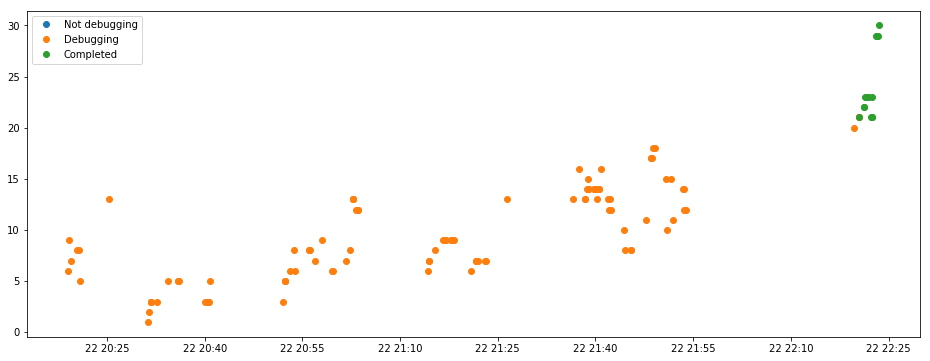

In [46]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

### Accumulated character difference

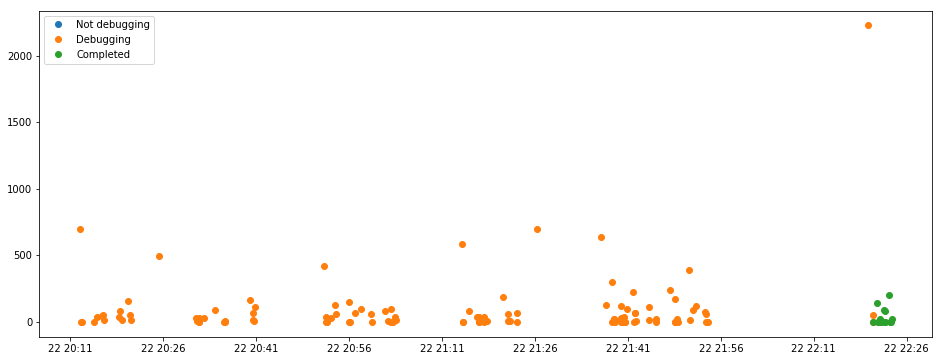

In [47]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_char_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_char_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_char_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

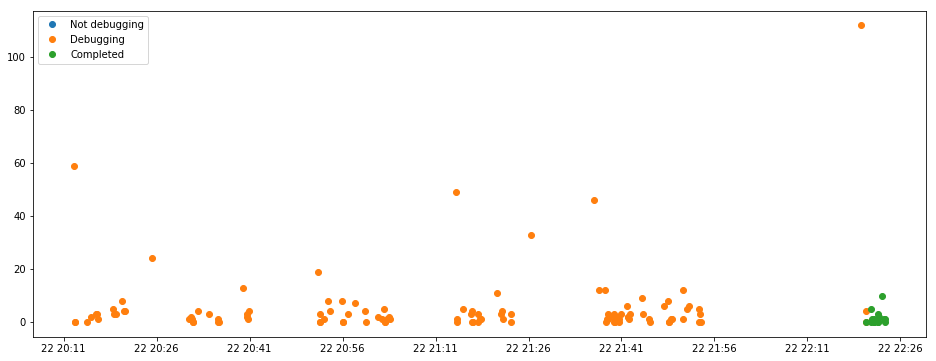

In [48]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

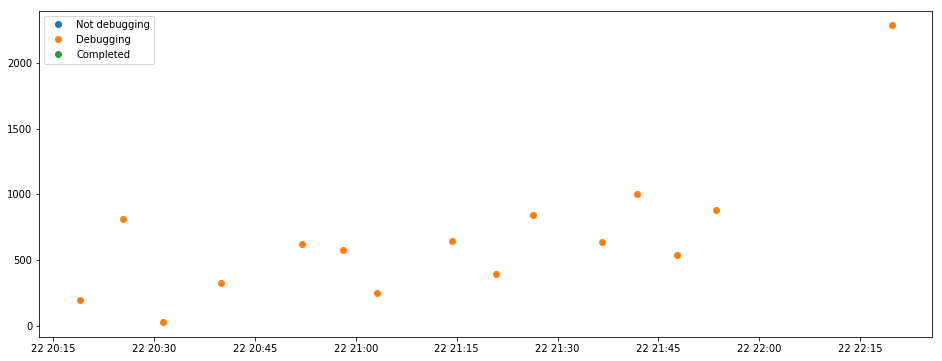

In [49]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_char_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_char_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_char_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

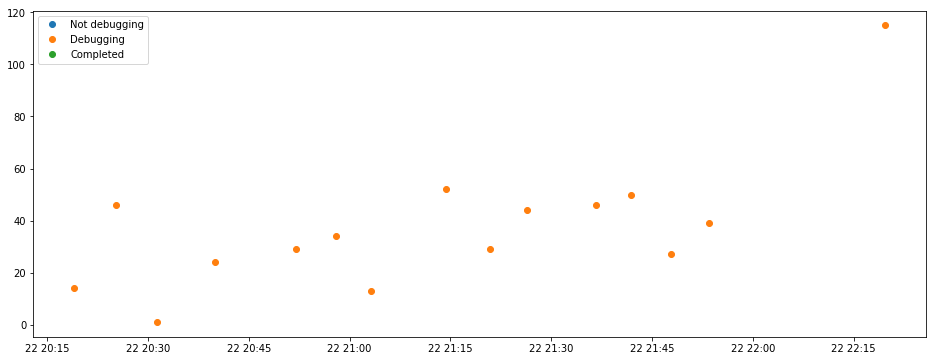

In [50]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

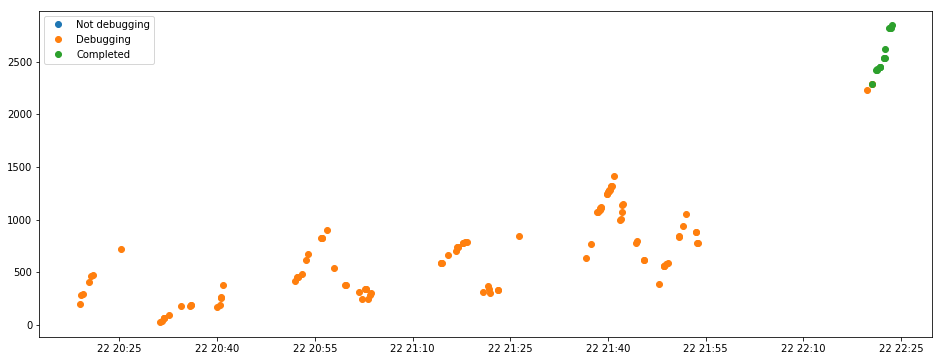

In [52]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

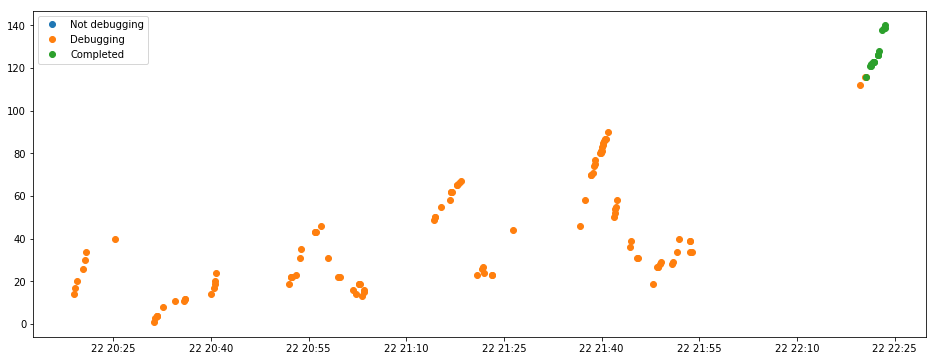

In [53]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

## Combined plots

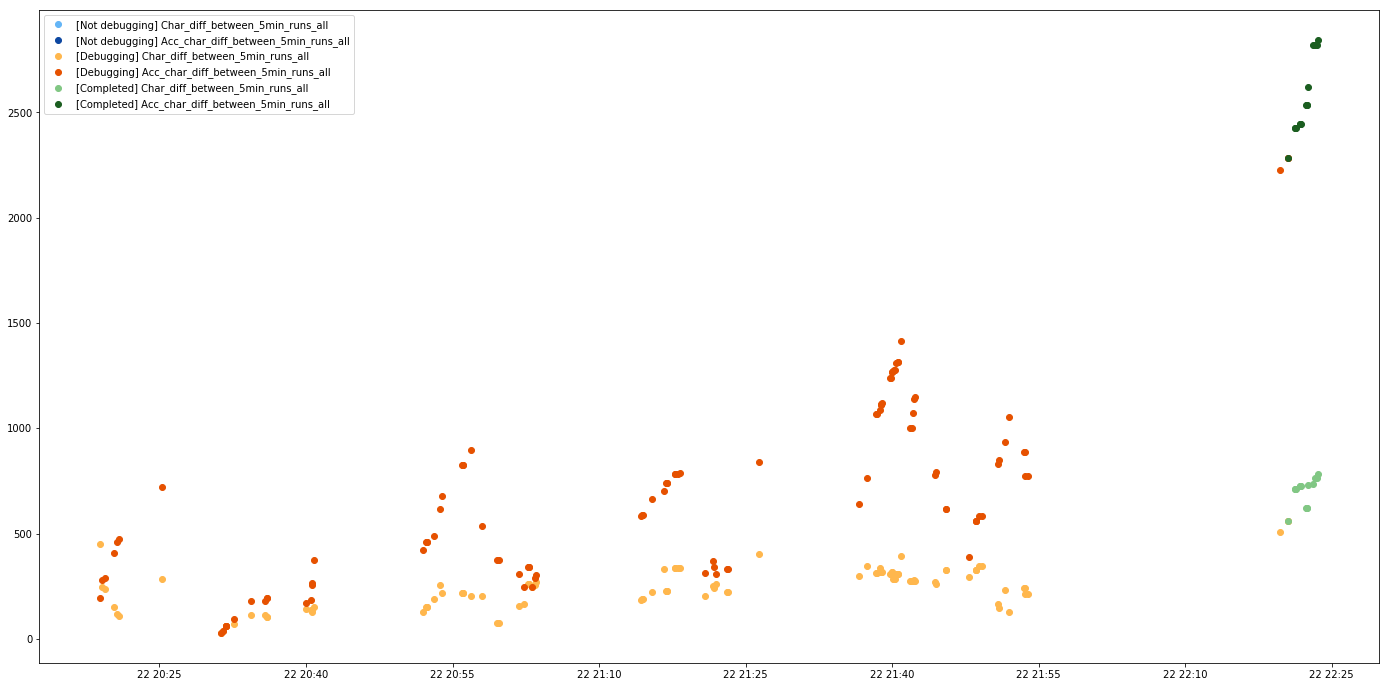

In [29]:
plt.figure(figsize=(24,12))
plt.plot(only_runs[not_debugging].Char_diff_between_5min_runs_all, marker='o',
         color="#64B5F6", linestyle="None", label='[Not debugging] Char_diff_between_5min_runs_all')
plt.plot(only_runs[not_debugging].Acc_char_diff_between_5min_runs_all, marker='o',
         color="#0D47A1", linestyle="None", label='[Not debugging] Acc_char_diff_between_5min_runs_all')
plt.plot(only_runs[debugging].Char_diff_between_5min_runs_all, marker='o',
         color="#FFB74D", linestyle="None", label='[Debugging] Char_diff_between_5min_runs_all')
plt.plot(only_runs[debugging].Acc_char_diff_between_5min_runs_all, marker='o',
         color="#E65100", linestyle="None", label='[Debugging] Acc_char_diff_between_5min_runs_all')
plt.plot(only_runs[completed].Char_diff_between_5min_runs_all, marker='o',
         color="#81C784", linestyle="None", label='[Completed] Char_diff_between_5min_runs_all')
plt.plot(only_runs[completed].Acc_char_diff_between_5min_runs_all, marker='o',
         color="#1B5E20", linestyle="None", label='[Completed] Acc_char_diff_between_5min_runs_all')

plt.legend()

### Runs between

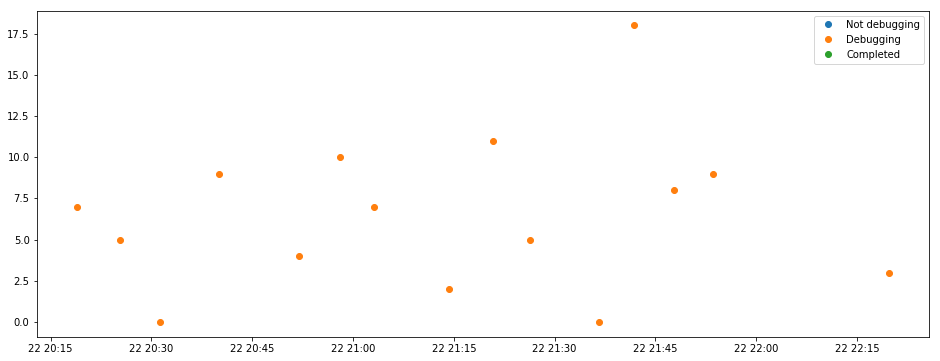

In [58]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Runs_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Runs_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Runs_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

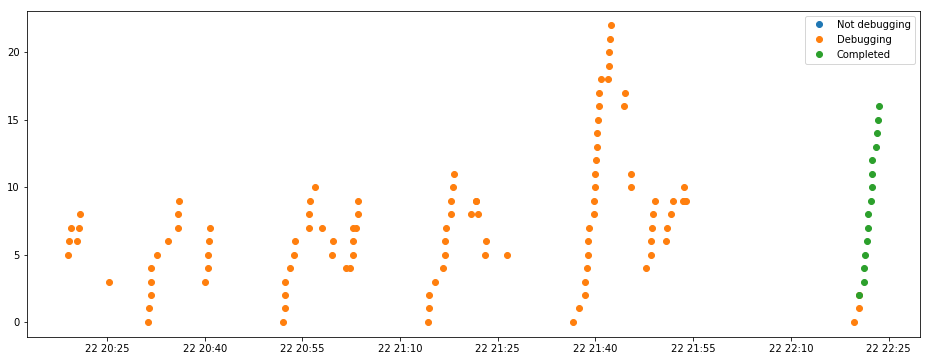

In [59]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

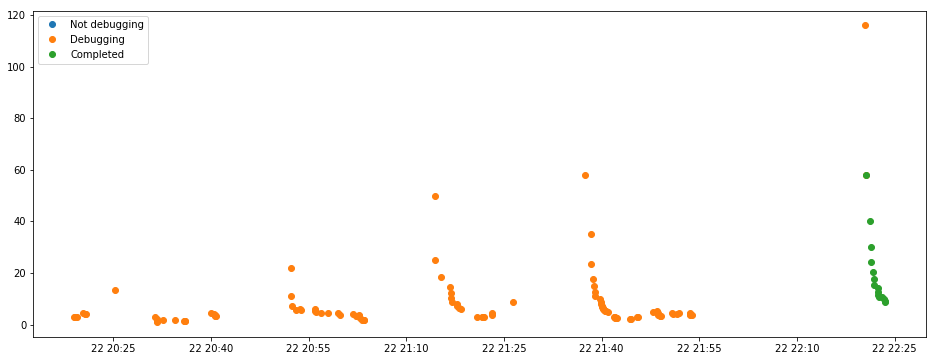

In [54]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all / only_runs[not_debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all / only_runs[debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all / only_runs[completed].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

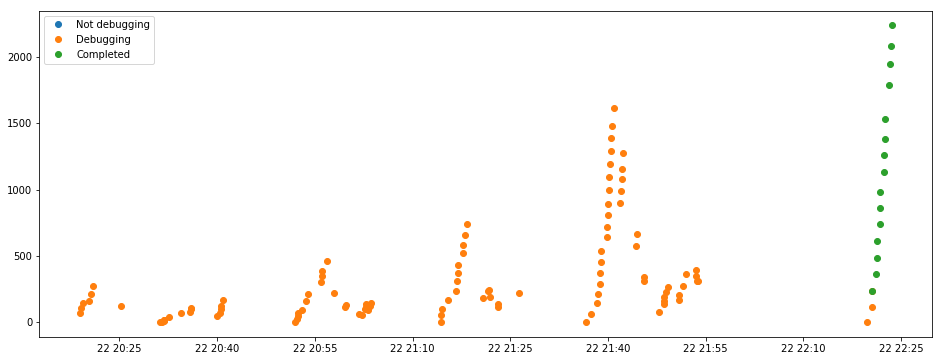

In [55]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all * only_runs[not_debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all * only_runs[debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all * only_runs[completed].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

### Completion

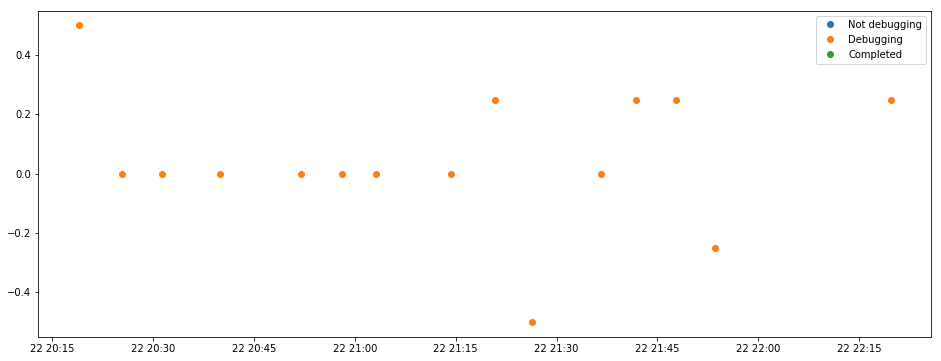

In [50]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Completion_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

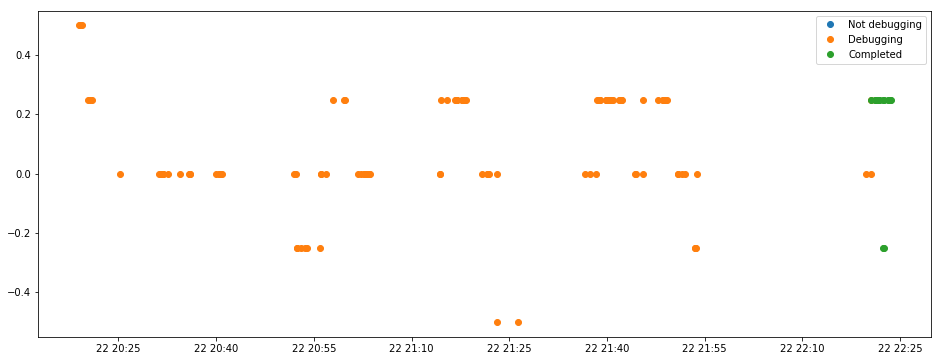

In [51]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Completion_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

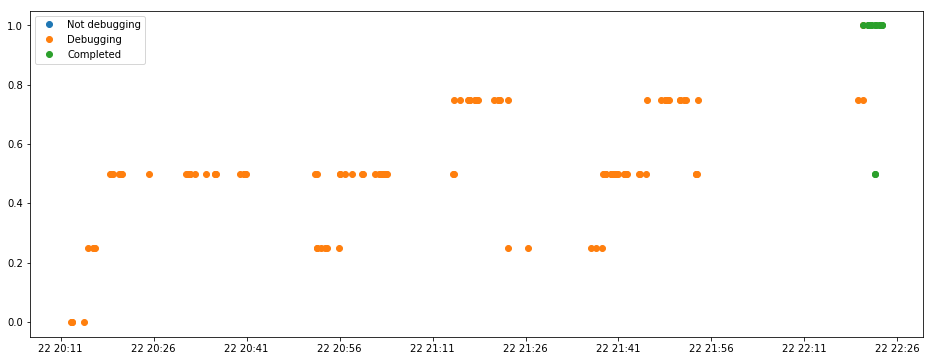

In [30]:
completion_per_run = df
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion1, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion1, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Completion1, marker='o', linestyle="None", label='Completed')
plt.legend()

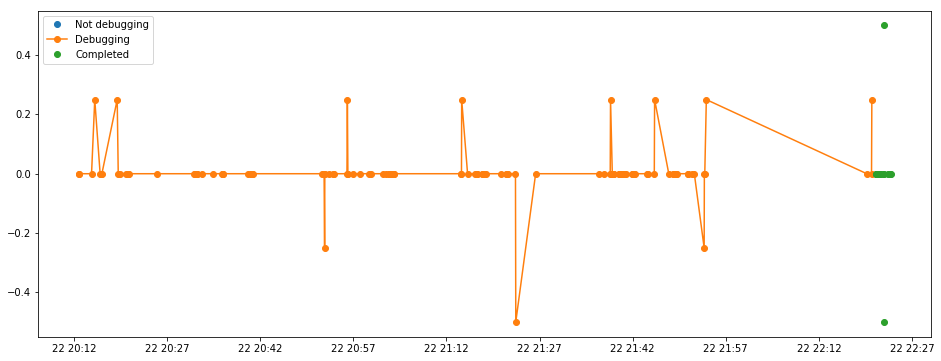

In [35]:
completion_per_run = df
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion1.diff(), marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion1.diff(), marker='o', label='Debugging')
plt.plot(only_runs[completed].Completion1.diff(), marker='o', linestyle="None", label='Completed')
plt.legend()

## Experiment 2, Part 1

In [ ]:
df['TotalRuns_ma10'] = df.TotalRuns.rolling(10).mean()

In [ ]:
df.TotalRuns_ma10

In [ ]:
df['Character_diff_ma10'] = df.character_diff1.ffill().rolling(10, min_periods=10).mean()

In [ ]:
df.Character_diff_ma10

In [ ]:
df['hypotese'] = df.Character_diff_ma10 / df.TotalRuns_ma10

In [ ]:
df.hypotese['2017-02-22 20:21:00':'2017-02-22 20:40:00']

In [ ]:
df_slice = df['2017-02-22 20:21:00':'2017-02-22 20:40:00'].copy()

In [ ]:
df_slice.hypotese.replace(np.inf,
                          df_slice.hypotese.replace(np.inf, 0).max() * 2,
                          inplace=True)

In [ ]:
df_slice.hypotese

In [ ]:
#plt.plot(df_slice.hypotese)
df_slice.hypotese.plot()

## Experiment #1

In [ ]:
df

In [ ]:
df['TotalRuns'] = df.JunitTest + df.Launch

In [ ]:
df['TotalRuns_ma10'] = df.TotalRuns.rolling(10).mean()

In [ ]:
df.TotalRuns_ma10

In [ ]:
df['SizeMeasure1_change'] = df.SizeMeasure1.diff().abs()

In [ ]:
df.SizeMeasure1_change

In [ ]:
df['SizeMeasure1_change_ma10'] = df.SizeMeasure1_change.rolling(10).mean()

In [ ]:
df.SizeMeasure1_change_ma10

In [ ]:
df['hypotese'] =df.SizeMeasure1_change_ma10 / df.TotalRuns_ma10

In [ ]:
df.hypotese['2017-02-22 20:21:00':'2017-02-22 20:40:00']

In [ ]:
df_slice = df['2017-02-22 20:21:00':'2017-02-22 20:40:00'].copy()

In [ ]:
df_slice.hypotese.replace(np.inf,
                          df_slice.hypotese.replace(np.inf, 0).max() * 2,
                          inplace=True)

In [ ]:
df_slice.hypotese

In [ ]:
df_slice.hypotese.plot()

In [ ]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

In [ ]:
fig, ax = plt.subplots()
xtick_locator = AutoDateLocator(minticks=6)
xtick_formatter = AutoDateFormatter(xtick_locator, defaultfmt='%H:%M')
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.plot(df_slice2)
plt.show()

## Possible features:

### Changes in size measure divived by how many times the code has been run
Using a moving average of 10 of both the difference in size measure and the total runs (Junit + Launch)

### Changes in size measure since last run.
Accumulate the size measure changes (diff) and reset every time we reach a run (either Junit or Launch)

### Time since last run in relative time (?)